<a href="https://colab.research.google.com/github/sharon-raj-1718/CE888/blob/main/assignment_1/sentiment_ce888.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#                  **TweetEval-based Multi-class tweet classification**









# Loading of libraries

In [36]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import urllib.request
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import f1_score
import re
import requests
import string
from nltk.corpus import stopwords
import seaborn as sns
import re
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import  CountVectorizer, TfidfVectorizer
from sklearn import svm

# Load the dataset

In [37]:
train_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/train_text.txt",encoding='utf-8',sep="\t", header=None)
train_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/train_labels.txt",encoding='utf-8',sep="\t", header=None)
validate_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/val_text.txt",encoding='utf-8',sep="\t", header=None)
validate_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/val_labels.txt",encoding='utf-8',sep="\t", header=None)
test_text = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/test_text.txt",encoding='utf-8',sep="\t", header=None)
test_label = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/test_labels.txt",encoding='utf-8',sep="\t", header=None)
map = pd.read_csv("https://raw.githubusercontent.com/cardiffnlp/tweeteval/main/datasets/sentiment/mapping.txt",encoding='utf-8',sep="\t", header=None)

In [39]:
train_text.columns= ["text"]
train_label.columns= ["label"]
validate_text.columns= ["text"]
validate_label.columns= ["label"]
test_text.columns= ["text"]
test_label.columns= ["label"]
map.columns= ["label","sentiment"]

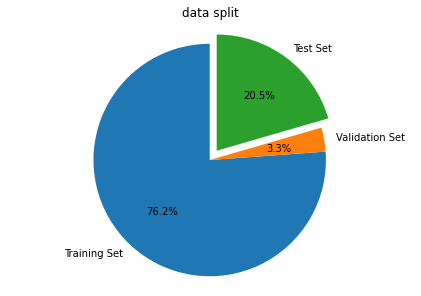

In [40]:
labels = ['Training Set', 'Validation Set', 'Test Set'] 
sizes = [len(train_label), len(validate_label), len(test_label)] 
explode = (0, 0, 0.1)
fig1, ax1 = plt.subplots() 
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
plt.tight_layout() 
plt.title("data split") 
plt.show()

# Preprocessing

In [41]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)


#Pulls Out all the HTML related tags ,unwanted characters and Amend text to lowercase

In [42]:
def clean_tweet(text):
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = text.strip().lower()
    filters='!"\'#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
    translate_dict = dict((c, " ") for c in filters)
    translate_map = str.maketrans(translate_dict)
    text = text.translate(translate_map)
    
    return text

# Tokenizing function used for all the data

In [43]:
def text_preprocessing(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    nopunc = clean_tweet(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    combined_text = ' '.join(tokenized_text)
    return combined_text

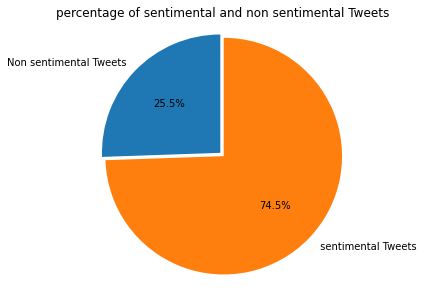

In [44]:
non_sen = train_label[train_label.label == 0].shape[0]
sen = train_label[train_label.label == 1].shape[0]

labels = ['Non sentimental Tweets', ' sentimental Tweets']
sizes = [non_sen,sen]
fig1, ax1 = plt.subplots()
explode = (0.02, 0.02)  
ax1.pie(sizes, explode= explode, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  
plt.tight_layout()
plt.title("percentage of sentimental and non sentimental Tweets")
plt.show()

#sucession the  dataframe and some further preprocessing

In [45]:

con_train = pd.concat([train_text,train_label], axis=1)
con_val = pd.concat([validate_text,validate_label], axis=1)
con_test = pd.concat([test_text,test_label], axis=1)

sentiment_train = pd.merge(con_train,map, on='label')
sentiment_validate = pd.merge(con_val,map, on='label')
sentiment_test = pd.merge(con_test,map, on='label')

train_validate = pd.concat([sentiment_train,sentiment_validate])

sentiment_train1 = train_validate.copy()
sentiment_train1['clean_t'] = sentiment_train1['text'].apply(str).apply(lambda x: text_preprocessing(x))
sentiment_train1['clean_t'] = sentiment_train1['clean_t'].str.replace('user','')
sentiment_train1['clean_t'] = sentiment_train1['clean_t'].str.replace('amp','')
sentiment_train1



,text,label,sentiment,clean_t
0,QT @user In the original draft of the 7th book...,2,positive,qt in the original draft of the 7th book remu...
1,@user Alciato: Bee will invest 150 million in ...,2,positive,alciato bee will invest 150 million in januar...
2,@user LIT MY MUM 'Kerry the louboutins I wonde...,2,positive,lit my mum kerry the louboutins i wonder how ...
3,"\"""" SOUL TRAIN\"""" OCT 27 HALLOWEEN SPECIAL ft ...",2,positive,soul train oct 27 halloween special ft t dot f...
4,"This is the last Sunday w/o football .....,NFL...",2,positive,this is the last sunday w o football nfl is ba...
...,...,...,...,...
1995,NaN,0,negative,nan
1996,NaN,0,negative,nan
1997,NaN,0,negative,nan
1998,NaN,0,negative,nan


In [9]:
sentiment_train1.dropna(axis='columns')

,label,sentiment,clean_t
0,2,positive,qt in the original draft of the 7th book remu...
1,2,positive,alciato bee will invest 150 million in januar...
2,2,positive,lit my mum kerry the louboutins i wonder how ...
3,2,positive,soul train oct 27 halloween special ft t dot f...
4,2,positive,this is the last sunday w o football nfl is ba...
...,...,...,...
1995,0,negative,nan
1996,0,negative,nan
1997,0,negative,nan
1998,0,negative,nan


In [46]:
df = sentiment_train1.apply (pd.to_numeric, errors='coerce')
df = sentiment_train1.dropna()
df

,text,label,sentiment,clean_t
0,QT @user In the original draft of the 7th book...,2,positive,qt in the original draft of the 7th book remu...
1,@user Alciato: Bee will invest 150 million in ...,2,positive,alciato bee will invest 150 million in januar...
2,@user LIT MY MUM 'Kerry the louboutins I wonde...,2,positive,lit my mum kerry the louboutins i wonder how ...
3,"\"""" SOUL TRAIN\"""" OCT 27 HALLOWEEN SPECIAL ft ...",2,positive,soul train oct 27 halloween special ft t dot f...
4,"This is the last Sunday w/o football .....,NFL...",2,positive,this is the last sunday w o football nfl is ba...
...,...,...,...,...
1941,According to Janet Jackson's long time produce...,0,negative,according to janet jacksons long time producer...
1942,Monday at Town Ballroom: RICHIE HAWTIN with LO...,0,negative,monday at town ballroom richie hawtin with loc...
1943,Disappointed the Knicks vs Nets game got cance...,0,negative,disappointed the knicks vs nets game got cance...
1944,"\""""@_eryflores: March 16 Luke Bryan is gonna a...",0,negative,eryflores march 16 luke bryan is gonna at the ...


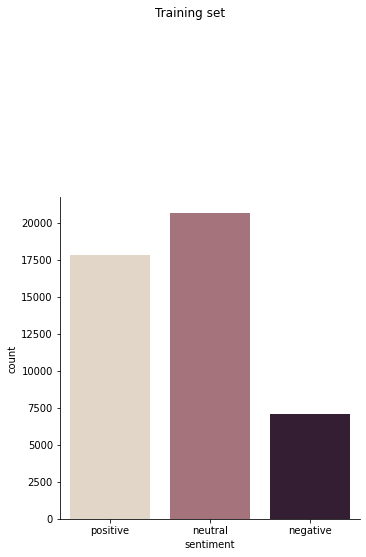

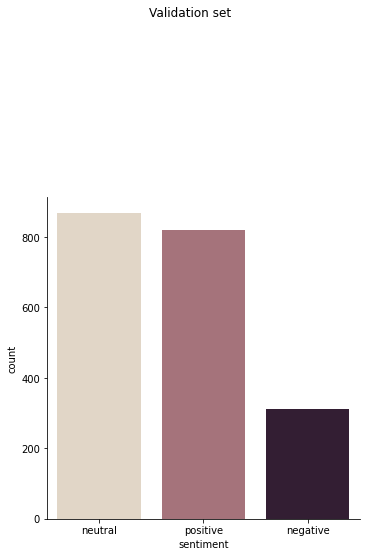

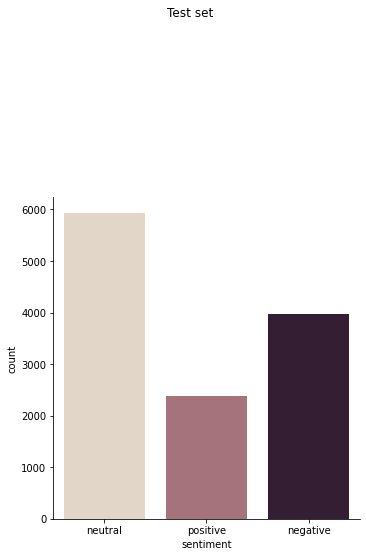

In [47]:
g = (sns.catplot(x="sentiment", kind="count", palette="ch:.25", data=sentiment_train))
g.fig.suptitle("Training set", y=1.5)
plt.show()

v = sns.catplot(x="sentiment", kind="count", palette="ch:.25", data=sentiment_validate)
v.fig.suptitle("Validation set", y=1.5)
plt.show()

t = sns.catplot(x="sentiment", kind="count", palette="ch:.25", data=sentiment_test)
t.fig.suptitle("Test set", y=1.5)
plt.show()

In [13]:
sentiment_1 = df[df ['sentiment'] == 'sentiment']['clean_t']
sentiment_0 = df[df ['sentiment'] == 'non-sentiment']['clean_t'] 


# Vectorizing for Offensive dataset

In [23]:
vectorizer = CountVectorizer(stop_words="english",preprocessor=clean_tweet,ngram_range=(1,2))
training_features = vectorizer.fit_transform(train_validate["text"].values.astype('U')) 
test_features = vectorizer.transform(df["text"].values.astype('U'))


In [15]:
test_features

<12284x2184143 sparse matrix of type '<class 'numpy.int64'>'
	with 113726 stored elements in Compressed Sparse Row format>

In [16]:
print(test_features)

  (0, 1082374)	1
  (0, 1257059)	1
  (0, 1400062)	1
  (0, 1810136)	1
  (0, 1810490)	1
  (0, 1955133)	2
  (0, 1993826)	1
  (0, 2014527)	1
  (1, 266343)	1
  (1, 563669)	1
  (1, 764753)	1
  (1, 765044)	1
  (1, 1333659)	1
  (1, 1383404)	1
  (1, 1416093)	1
  (1, 2052058)	1
  (2, 403519)	1
  (2, 405664)	1
  (2, 740049)	1
  (2, 1186185)	1
  (2, 1803926)	1
  (2, 1804243)	1
  (2, 1814251)	1
  (2, 1955133)	2
  (2, 2009553)	1
  :	:
  (12259, 1257862)	1
  (12260, 1257862)	1
  (12261, 1257862)	1
  (12262, 1257862)	1
  (12263, 1257862)	1
  (12264, 1257862)	1
  (12265, 1257862)	1
  (12266, 1257862)	1
  (12267, 1257862)	1
  (12268, 1257862)	1
  (12269, 1257862)	1
  (12270, 1257862)	1
  (12271, 1257862)	1
  (12272, 1257862)	1
  (12273, 1257862)	1
  (12274, 1257862)	1
  (12275, 1257862)	1
  (12276, 1257862)	1
  (12277, 1257862)	1
  (12278, 1257862)	1
  (12279, 1257862)	1
  (12280, 1257862)	1
  (12281, 1257862)	1
  (12282, 1257862)	1
  (12283, 1257862)	1


# Training the model

In [24]:
model = LinearSVC()
model.fit(training_features, train_validate["sentiment"])
y_pred = model.predict(test_features)

# Evaluation metrics

In [26]:
score = f1_score(df["sentiment"], y_pred,average='macro')

print("Accuracy for the sentiment: {:.2f}".format(score*100,2))

Accuracy for the sentiment: 99.85
